In [1]:
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import pandas as pd
from sklearn import preprocessing
from math import floor

In [2]:
class Model:
    def __init__(self, model_id, binary_features):
        self.model_id = model_id
        self.binary_features = binary_features
        self.error = None
        self.metric = None
        self.fitness = None

In [3]:
def initialization(feature_list, n_models, gen):
    """ Initialize n models with 1 or 0 for each feature """
    model_list = []
    for i in range(n_models):
        model_id = f"{gen}_{i}"
        binary_features = [random.getrandbits(1) for i in range(len(feature_list))]
        model_list.append(Model(model_id, binary_features))
    return model_list

In [4]:
def fitness_assignment(model_list, input_data, feature_list):
    """ Get the fitness of each model """

    for model_obj in model_list:
        chosen_cols = [feat for feat,bin in zip(feature_list,model_obj.binary_features) if bin]
        
        X = input_data[chosen_cols] # Features
        x = X.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        X = pd.DataFrame(x_scaled)
        
        y = input_data.label # Target variable
        # split X and y into training and testing sets
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)    

        logreg = LogisticRegression(solver='lbfgs')

        # fit the model with data
        logreg.fit(X_train,y_train)

        #
        y_pred=logreg.predict(X_test)


        y_pred_proba = logreg.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        
        setattr(model_obj, "error", 1-auc)
        setattr(model_obj, "metric", auc)

    # Selective pressure (between 1 and 2)
    k = 1.5
    # Highest error first
    model_list.sort(key=lambda x: x.error, reverse=True)
    # Assign each model the fitness corresponding to the rank
    for rank, model_obj in enumerate(model_list):
        setattr(model_obj, "fitness", k*rank)
    
    model_list.sort(key=lambda x: x.fitness, reverse=True)
    
    return model_list

In [5]:
def weighted_random_choice(model_list):
    """ Randomly pick a model, giving precedent to those with higher fitness """
    max = sum(model.fitness for model in model_list)
    pick = random.uniform(0, max)
    current = 0
    for model in model_list:
        current += model.fitness
        if current > pick:
            return model

In [6]:
def selection(N, model_list):
    """ Select N/2 individuals according to fitness. Assumes model_list has highest fitness first """
    elitism = 1
    n_selected_individuals = N/2
    selected_individuals = []
    # First select elite individuals
    for i in range(elitism):
        selected_individuals.append(model_list[i])
    
    # Then select individuals randomly based on their proportion of fit
    fitness_list = None
    
    for i in range(round(n_selected_individuals - elitism)):
        selected_model = weighted_random_choice(model_list)
#         print(f"Selected Model Error: {selected_model.error}")
        selected_individuals.append(selected_model)
        
    return selected_individuals

In [7]:
def compute_crossover(parent_models):
    """ Computes the actual crossover of features """
    parent_features = [(a,b) for a,b in zip(parent_models[0].binary_features, 
                                            parent_models[1].binary_features)]
    output_features = []
    for feature in parent_features:
        pick = random.uniform(0, 1)
        output_features.append(feature[0] if pick < 0.5 else feature[1])
#     print(f"Left Parent: {parent_models[0].binary_features}, Right Parent: {parent_models[1].binary_features}")
#     print(f"Child: {output_features}")
    return output_features

In [8]:
def crossover(model_list, N, gen):
    """ Creates children models from parents """
    parent_models = random.sample(model_list, 2)
    child_models = []
    for i in range(N):
        new_features = compute_crossover(parent_models)
        model_id = f"{gen}_{i}"
        child_models.append(Model(model_id, new_features))
    return child_models

In [9]:
def mutation(model_list):
    """ Mutates one gene of each model """
    feature_len = len(model_list[0].binary_features)
    mutation_rate = 1/(feature_len)
    for model_obj in model_list:
        new_binary_features = []
#         print(model_obj.model_id)
        for feature in model_obj.binary_features:
            pick = random.uniform(0, 1)
#             print(f"Pick: {pick}")
#             print(f"mutation_rate {mutation_rate}")
            if pick < mutation_rate:
                new_fetaure = int(not feature)
#                 print(f"Old: {feature}, New: {new_fetaure}")
                new_binary_features.append(new_fetaure)
            else:
#                 print("\t PASS")
                new_binary_features.append(feature)
#         print(f"Old: {model_obj.binary_features}, New: {new_binary_features}")
        model_obj.binary_features = new_binary_features
    return model_list

In [10]:
def get_mix_of_children_and_random(model_list, n_models, gen):
    ### Keep the top two parents from each round, generate half children and half random
    # Get top two models
    child_model_list = [*model_list]
    
    # Get children of parents - remove two for parents
    n_children = floor(n_models/2 - 2)
    model_list = crossover(model_list, n_children, gen)
    model_list = mutation(model_list)
    child_model_list += model_list
    
    # Get new set of random children
    n_random_models = floor(n_models/2)
    generated_model_list = initialization(model_list[0].binary_features, n_models, gen)
    child_model_list += generated_model_list
    
    return child_model_list

In [11]:
def always_children_keep_parents(model_list, n_models, gen):
    ### Keep the top two parents from each round, generate only children
    # Get top two models
    child_model_list = [*model_list]
    
    # Get children of parents - remove two for parents
    n_children = floor(n_models - 2)
    model_list = crossover(model_list, n_children, gen)
    model_list = mutation(model_list)
    child_model_list += model_list
    
    return child_model_list

In [12]:
def test_functions():
    
    print("\nTest Initialisation\n")
    for model_obj in initialization(["a","b","c"],4, 0):
        print(model_obj.binary_features)
    
    
    print("\nTest Selection\n")
    model_one = Model("0_1",[0,1,1])
    model_two = Model("0_2",[1,0,1])
    model_three = Model("0_3",[0,0,1])
    model_four = Model("0_4",[1,0,0])
    setattr(model_one, "fitness", 0.2)
    setattr(model_two, "fitness", 0.4)
    setattr(model_three, "fitness", 0.6)
    setattr(model_four, "fitness", 0.8)
    selected_models = selection(4, [model_one, model_two, model_three, model_four])
    for model_obj in selected_models:
        print(model_obj.binary_features)
        
    model_list = [Model("0_1",[1,1,1]),Model("0_2",[0,0,0])]
    
    print("\nTest Crossover\n")
    child_models = crossover(model_list, 4, 1)
    for model_obj in child_models:
        print(model_obj.binary_features)
  
    print("\nTest Mutation\n")
    mutated_models = mutation(model_list)
    for model_obj in mutated_models:
        print(model_obj.binary_features)

In [13]:
test_functions()


Test Initialisation

[1, 0, 0]
[0, 0, 0]
[0, 0, 1]
[0, 1, 0]

Test Selection

[0, 1, 1]
[0, 1, 1]

Test Crossover

[1, 0, 1]
[1, 1, 1]
[0, 0, 1]
[0, 1, 1]

Test Mutation

[1, 0, 0]
[1, 0, 0]


In [14]:
def run_feature_selection_one_family_tree_always_best_parents(n_models, generations, feature_list, dataset):
    """ Run the feature selection algorithm """
    model_list = initialization(feature_list, n_models, 0)
    model_errors = []
    model_metrics = []
    best_model = None
    best_num = 100
    for gen in range(generations):
        model_list = fitness_assignment(model_list, dataset, feature_list)
        if gen % round(generations/10) == 0:
            print(f"Gen: {gen}, {[model_obj.error for model_obj in model_list]}")
        model_errors.append([model_obj.error for model_obj in model_list])
        model_metrics.append([model_obj.metric for model_obj in model_list])
        # Find the best feature set
        if model_list[0].error < best_num:
            best_model = model_list[0]
        model_list = selection(n_models, model_list)
        model_list = always_children_keep_parents(model_list, n_models, gen)
    return (model_errors, model_metrics, best_model)

In [15]:
def run_feature_selection_one_family_tree(n_models, generations, feature_list, dataset):
    """ Run the feature selection algorithm """
    model_list = initialization(feature_list, n_models, 0)
    model_errors = []
    model_metrics = []
    best_model = None
    best_num = 100
    for gen in range(generations):
        model_list = fitness_assignment(model_list, dataset, feature_list)
        if gen % round(generations/10) == 0:
            print(f"Gen: {gen}, {[model_obj.error for model_obj in model_list]}")
        model_errors.append([model_obj.error for model_obj in model_list])
        model_metrics.append([model_obj.metric for model_obj in model_list])
        # Find the best feature set
        if model_list[0].error < best_num:
            best_model = model_list[0]
        model_list = selection(n_models, model_list)
        model_list = crossover(model_list, n_models, gen)
        model_list = mutation(model_list)
    return (model_errors, model_metrics, best_model)

In [16]:
def run_feature_selection_more_random(n_models, generations, feature_list, dataset):
    """ Run the feature selection algorithm """
    model_list = initialization(feature_list, n_models, 0)
    model_errors = []
    model_metrics = []
    best_model = None
    best_num = 100
    for gen in range(generations):
        model_list = fitness_assignment(model_list, dataset, feature_list)
        if gen % round(generations/10) == 0:
            print(f"Gen: {gen}, {[model_obj.error for model_obj in model_list]}")
        model_errors.append([model_obj.error for model_obj in model_list])
        model_metrics.append([model_obj.metric for model_obj in model_list])
        # Find the best feature set
        if model_list[0].error < best_num:
            best_model = model_list[0]
        model_list = selection(n_models, model_list)
        model_list = get_mix_of_children_and_random(model_list, n_models, gen)
    return (model_errors, model_metrics, best_model)

In [17]:
def plot_errors(error_list):
    x_values = list(map(list, zip(*error_list)))
    y = list(range(len(error_list)))
    for i, x in enumerate(x_values):
        plt.plot(y, x, label = f"line {i}")
    plt.xlabel('x - axis')
    plt.ylabel('y - axis')
    plt.show()

In [18]:
def plot_cum_errors(error_list):
    x_values = list(map(list, zip(*error_list)))
    y = list(range(1,len(error_list)+1))
    for i, x in enumerate(x_values):
        cum_x = np.divide(np.cumsum(x),y)
        plt.plot(y, cum_x, label = f"line {i}")
    plt.xlabel('x - axis')
    plt.ylabel('y - axis')
    plt.show()

In [19]:
%load_ext autotime

In [15]:
%%markdown 
# Diabetes

# Diabetes


In [16]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
diabetes = pd.read_csv("diabetes.csv", header=0, names=col_names)
feature_list = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']
model_errors, model_metrics, best_model_d = run_feature_selection(n_models=10,
                                                    generations=100,
                                                    feature_list=feature_list,
                                                    dataset=diabetes)

Gen: 0, [0.1619106699751861, 0.16873449131513651, 0.16935483870967738, 0.19751861042183627, 0.20471464019851116, 0.25136476426799015, 0.2668734491315137, 0.2760545905707197, 0.284863523573201, 0.40638957816377164]
Gen: 1, [0.1575682382133995, 0.16141439205955332, 0.16141439205955332, 0.16141439205955332, 0.1619106699751861, 0.1761786600496278, 0.1780397022332506, 0.2082506203473946, 0.21098014888337469, 0.3614143920595534]
Gen: 2, [0.15446650124069483, 0.1575682382133995, 0.1575682382133995, 0.1575682382133995, 0.1575682382133995, 0.15806451612903227, 0.1761786600496278, 0.1780397022332506, 0.28883374689826313, 0.4007444168734492]
Gen: 3, [0.14230769230769225, 0.1504962779156327, 0.15124069478908186, 0.1523573200992555, 0.1575682382133995, 0.1575682382133995, 0.1575682382133995, 0.15806451612903227, 0.1760545905707196, 0.28883374689826313]
Gen: 4, [0.13039702233250627, 0.14230769230769225, 0.14230769230769225, 0.14230769230769225, 0.14230769230769225, 0.14230769230769225, 0.14230769230

Gen: 39, [0.13039702233250627, 0.13039702233250627, 0.13039702233250627, 0.13039702233250627, 0.13126550868486353, 0.14230769230769225, 0.1435483870967742, 0.1671215880893301, 0.18858560794044665, 0.31848635235732015]
Gen: 40, [0.13039702233250627, 0.13039702233250627, 0.13039702233250627, 0.13039702233250627, 0.13039702233250627, 0.13126550868486353, 0.13523573200992567, 0.13523573200992567, 0.1413151364764268, 0.14230769230769225]
Gen: 41, [0.13039702233250627, 0.13039702233250627, 0.13039702233250627, 0.13126550868486353, 0.13982630272952856, 0.14230769230769225, 0.1435483870967742, 0.1435483870967742, 0.1642679900744416, 0.240818858560794]
Gen: 42, [0.13039702233250627, 0.13039702233250627, 0.13126550868486353, 0.13498759305210917, 0.14230769230769225, 0.14230769230769225, 0.14230769230769225, 0.15124069478908186, 0.15372208436724577, 0.16141439205955332]
Gen: 43, [0.13126550868486353, 0.13387096774193552, 0.1394540942928041, 0.14230769230769225, 0.14230769230769225, 0.142307692307

Gen: 79, [0.13523573200992567, 0.13523573200992567, 0.13523573200992567, 0.1503722084367245, 0.1504962779156327, 0.1573200992555831, 0.15806451612903227, 0.1688585607940447, 0.1688585607940447, 0.26302729528535984]
Gen: 80, [0.13523573200992567, 0.14454094292803965, 0.14751861042183623, 0.1504962779156327, 0.1504962779156327, 0.1571960297766749, 0.1573200992555831, 0.15806451612903227, 0.24491315136476421, 0.25111662531017365]
Gen: 81, [0.13126550868486353, 0.13523573200992567, 0.14454094292803965, 0.1504962779156327, 0.15372208436724566, 0.16141439205955332, 0.1692307692307694, 0.2450372208436724, 0.26302729528535984, 0.28287841191067]
Gen: 82, [0.1394540942928041, 0.1504962779156327, 0.1504962779156327, 0.16141439205955332, 0.16699751861042178, 0.1671215880893301, 0.17729528535980144, 0.17729528535980144, 0.24491315136476421, 0.28337468982630276]
Gen: 83, [0.13523573200992567, 0.16699751861042178, 0.1691066997518611, 0.17022332506203475, 0.17729528535980144, 0.17729528535980144, 0.17

In [27]:
print(best_model_d.error)
print(best_model_d.fitness)
print(best_model_d.metric)
print(best_model_d.model_id)

0.13039702233250627
13.5
0.8696029776674937
98_3


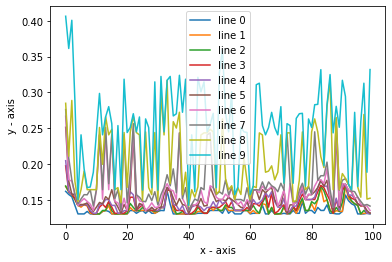

In [17]:
plot_errors(error_list=model_errors)

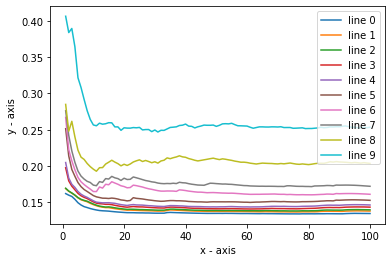

In [18]:
plot_cum_errors(error_list=model_errors)

In [19]:
%%markdown 
# Mice

# Mice


In [26]:

col_names = ["MouseID", "DYRK1A_N", "ITSN1_N", "BDNF_N", "NR1_N", "NR2A_N", "pAKT_N", "pBRAF_N", "pCAMKII_N", "pCREB_N", "pELK_N", "pERK_N", "pJNK_N", "PKCA_N", "pMEK_N", "pNR1_N", "pNR2A_N", "pNR2B_N", "pPKCAB_N", "pRSK_N", "AKT_N", "BRAF_N", "CAMKII_N", "CREB_N", "ELK_N", "ERK_N", "GSK3B_N", "JNK_N", "MEK_N", "TRKA_N", "RSK_N", "APP_N", "Bcatenin_N", "SOD1_N", "MTOR_N", "P38_N", "pMTOR_N", "DSCR1_N", "AMPKA_N", "NR2B_N", "pNUMB_N", "RAPTOR_N", "TIAM1_N", "pP70S6_N", "NUMB_N", "P70S6_N", "pGSK3B_N", "pPKCG_N", "CDK5_N", "S6_N", "ADARB1_N", "AcetylH3K9_N", "RRP1_N", "BAX_N", "ARC_N", "ERBB4_N", "nNOS_N", "Tau_N", "GFAP_N", "GluR3_N", "GluR4_N", "IL1B_N", "P3525_N", "pCASP9_N", "PSD95_N", "SNCA_N", "Ubiquitin_N", "pGSK3B_Tyr216_N", "SHH_N", "BAD_N", "BCL2_N", "pS6_N", "pCFOS_N", "SYP_N", "H3AcK18_N", "EGR1_N", "H3MeK4_N", "CaNA_N", "Genotype", "Treatment", "Behavior", "class", "label"]
dataset = pd.read_csv("Data_Cortex_Nuclear.csv", header=0, names=col_names).fillna(0)


feature_list = ["DYRK1A_N", "ITSN1_N", "BDNF_N", "NR1_N", "NR2A_N", "pAKT_N", "pBRAF_N", "pCAMKII_N", "pCREB_N", "pELK_N", "pERK_N", "pJNK_N", "PKCA_N", "pMEK_N", "pNR1_N", "pNR2A_N", "pNR2B_N", "pPKCAB_N", "pRSK_N", "AKT_N", "BRAF_N", "CAMKII_N", "CREB_N", "ELK_N", "ERK_N", "GSK3B_N", "JNK_N", "MEK_N", "TRKA_N", "RSK_N", "APP_N", "Bcatenin_N", "SOD1_N", "MTOR_N", "P38_N", "pMTOR_N", "DSCR1_N", "AMPKA_N", "NR2B_N", "pNUMB_N", "RAPTOR_N", "TIAM1_N", "pP70S6_N", "NUMB_N", "P70S6_N", "pGSK3B_N", "pPKCG_N", "CDK5_N", "S6_N", "ADARB1_N", "AcetylH3K9_N", "RRP1_N", "BAX_N", "ARC_N", "ERBB4_N", "nNOS_N", "Tau_N", "GFAP_N", "GluR3_N", "GluR4_N", "IL1B_N", "P3525_N", "pCASP9_N", "PSD95_N", "SNCA_N", "Ubiquitin_N", "pGSK3B_Tyr216_N", "SHH_N", "BAD_N", "BCL2_N", "pS6_N", "pCFOS_N", "SYP_N", "H3AcK18_N", "EGR1_N", "H3MeK4_N", "CaNA_N"]
model_errors, model_metrics, best_model_m = run_feature_selection(n_models=100,
                                                    generations=2000,
                                                    feature_list=feature_list,
                                                    dataset=dataset)



NameError: name 'run_feature_selection' is not defined

In [42]:
model_errors[-1][0]

0.09467098402941665

In [53]:
[0.07853575544701175, 0.07957850831458202, 0.07968827177432625, 0.07968827177432625, 0.07968827177432625, 0.07968827177432625, 0.07968827177432625, 0.07968827177432625, 0.07968827177432625, 0.07968827177432625, 0.07968827177432625, 0.07968827177432625, 0.0816640140497229, 0.08429833708358492, 0.08616431589923712, 0.09247571483453165, 0.10048844739586194, 0.11311124526645089, 0.11733713846660454, 0.13127709785412445]

[0.07853575544701175,
 0.07957850831458202,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.0816640140497229,
 0.08429833708358492,
 0.08616431589923712,
 0.09247571483453165,
 0.10048844739586194,
 0.11311124526645089,
 0.11733713846660454,
 0.13127709785412445]

In [49]:
min([item for sublist in model_errors for item in sublist])

0.07853575544701175

In [52]:
[item for sublist in model_errors for item in sublist].index(0.07853575544701175)/20

657.0

In [76]:
sorted([model[0] for model in model_errors])[0:30]

[0.07853575544701175,
 0.07913945447560511,
 0.07913945447560511,
 0.07924921793534945,
 0.07941386312496568,
 0.07968827177432625,
 0.07968827177432625,
 0.07968827177432625,
 0.0798529169639427,
 0.07985291696394281,
 0.07985291696394281,
 0.08051149772240829,
 0.08073102464189674,
 0.08127984194061788,
 0.0816640140497229,
 0.0817188957795949,
 0.08177377750946713,
 0.08188354096921147,
 0.08188354096921147,
 0.08188354096921147,
 0.08188354096921147,
 0.0820481861588277,
 0.08210306788869981,
 0.08210306788869981,
 0.08226771307831626,
 0.08226771307831626,
 0.08287141210690963,
 0.08287141210690963,
 0.0831458207562702,
 0.08336534767575876]

In [77]:
[model[0] for model in model_errors].index(0.08336534767575876)

560

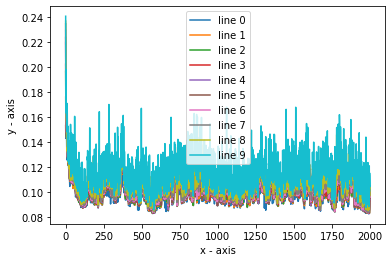

In [30]:
plot_errors(error_list=model_errors)

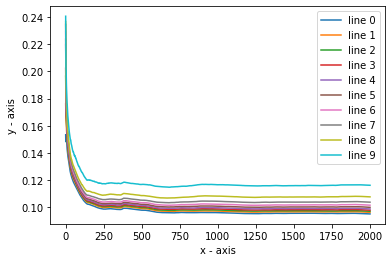

In [31]:
plot_cum_errors(error_list=model_errors)

In [19]:
print(best_model_m.error)
print(best_model_m.fitness)
print(best_model_m.metric)
print(best_model_m.model_id)

0.09900664068931442
148.5
0.9009933593106856
1998_36


In [8]:
%%markdown 
# Test One Family Tree Vs More Random

# Test One Family Tree Vs More Random


Gen: 0, [0.14807090719499483, 0.15328467153284675, 0.1586081993304429, 0.15915701662916426, 0.15981559738762963, 0.16096811371494424, 0.16184622139289828, 0.16272432907085232, 0.16640140497228473, 0.16826738378793693, 0.16903572800614675, 0.16974919049448445, 0.1721091048789859, 0.17221886833873, 0.1732067394764284, 0.1750727182920806, 0.17567641732067396, 0.1775972778661984, 0.1802316009000604, 0.18429284891059772, 0.18434773064046983, 0.18500631139893542, 0.18566489215740078, 0.1889577959497284, 0.19076889303550837, 0.1934032160693705, 0.1934032160693706, 0.19603753910323263, 0.19609242083310474, 0.19757422753965204, 0.19784863618901272, 0.19954996981504858, 0.19971461500466503, 0.2010866582514681, 0.20190988419955003, 0.20234893803852694, 0.2025684649580155, 0.20289775533724808, 0.20372098128533012, 0.20372098128533023, 0.20394050820481857, 0.20448932550353993, 0.2051479062620054, 0.20531255145162175, 0.20575160529059877, 0.20619065912957568, 0.20701388507765772, 0.20833104659458868

Gen: 40, [0.1014763185335601, 0.10246418967125848, 0.10262883486087482, 0.10268371659074693, 0.10301300696997973, 0.10334229734921241, 0.10345206080895675, 0.10345206080895675, 0.10378135118818943, 0.10383623291806166, 0.10383623291806166, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.10394599637780588, 0.104000878107678, 0.10405575983755011, 0.10405575983755011, 0.10454969540639925, 0.10460457713627136, 0.10476922232588781, 0.1047

C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Gen: 60, [0.09697601668404598, 0.09867735031008174, 0.09917128587893098, 0.09993963009714069, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547828, 0.10065309258547839, 0.10070797431535039, 0.10114702815432741, 0.10125679161407175, 0.10131167334394375, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.1014763185335602, 0.10153120026343232, 0.10197025410240945, 0.10202513583228145, 0.1021897810218978, 0.10235442621151425, 0.10240930794138625, 0.10240930794138625, 0.10240930794138625, 0.10240930794138625, 0.10240930794138625, 0.10240930794138625, 0.10240930794138625, 0.10251907140113059, 0.10268371659074693, 0.10273859832061

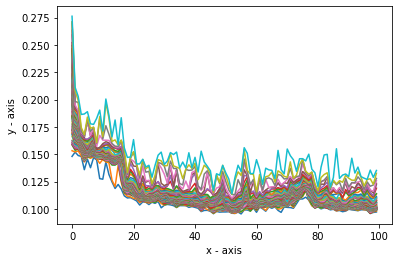

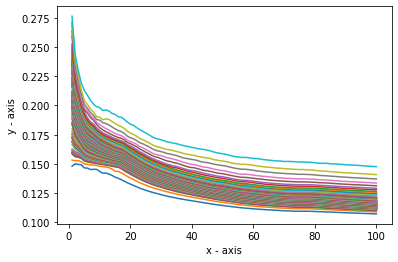

model_id: 98_21
binary_features: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
error: 0.09725042533340666
metric: 0.9027495746665933
fitness: 148.5
time: 8min 19s


In [396]:

col_names = ["MouseID", "DYRK1A_N", "ITSN1_N", "BDNF_N", "NR1_N", "NR2A_N", "pAKT_N", "pBRAF_N", "pCAMKII_N", "pCREB_N", "pELK_N", "pERK_N", "pJNK_N", "PKCA_N", "pMEK_N", "pNR1_N", "pNR2A_N", "pNR2B_N", "pPKCAB_N", "pRSK_N", "AKT_N", "BRAF_N", "CAMKII_N", "CREB_N", "ELK_N", "ERK_N", "GSK3B_N", "JNK_N", "MEK_N", "TRKA_N", "RSK_N", "APP_N", "Bcatenin_N", "SOD1_N", "MTOR_N", "P38_N", "pMTOR_N", "DSCR1_N", "AMPKA_N", "NR2B_N", "pNUMB_N", "RAPTOR_N", "TIAM1_N", "pP70S6_N", "NUMB_N", "P70S6_N", "pGSK3B_N", "pPKCG_N", "CDK5_N", "S6_N", "ADARB1_N", "AcetylH3K9_N", "RRP1_N", "BAX_N", "ARC_N", "ERBB4_N", "nNOS_N", "Tau_N", "GFAP_N", "GluR3_N", "GluR4_N", "IL1B_N", "P3525_N", "pCASP9_N", "PSD95_N", "SNCA_N", "Ubiquitin_N", "pGSK3B_Tyr216_N", "SHH_N", "BAD_N", "BCL2_N", "pS6_N", "pCFOS_N", "SYP_N", "H3AcK18_N", "EGR1_N", "H3MeK4_N", "CaNA_N", "Genotype", "Treatment", "Behavior", "class", "label"]
dataset = pd.read_csv("Data_Cortex_Nuclear.csv", header=0, names=col_names).fillna(0)


feature_list = ["DYRK1A_N", "ITSN1_N", "BDNF_N", "NR1_N", "NR2A_N", "pAKT_N", "pBRAF_N", "pCAMKII_N", "pCREB_N", "pELK_N", "pERK_N", "pJNK_N", "PKCA_N", "pMEK_N", "pNR1_N", "pNR2A_N", "pNR2B_N", "pPKCAB_N", "pRSK_N", "AKT_N", "BRAF_N", "CAMKII_N", "CREB_N", "ELK_N", "ERK_N", "GSK3B_N", "JNK_N", "MEK_N", "TRKA_N", "RSK_N", "APP_N", "Bcatenin_N", "SOD1_N", "MTOR_N", "P38_N", "pMTOR_N", "DSCR1_N", "AMPKA_N", "NR2B_N", "pNUMB_N", "RAPTOR_N", "TIAM1_N", "pP70S6_N", "NUMB_N", "P70S6_N", "pGSK3B_N", "pPKCG_N", "CDK5_N", "S6_N", "ADARB1_N", "AcetylH3K9_N", "RRP1_N", "BAX_N", "ARC_N", "ERBB4_N", "nNOS_N", "Tau_N", "GFAP_N", "GluR3_N", "GluR4_N", "IL1B_N", "P3525_N", "pCASP9_N", "PSD95_N", "SNCA_N", "Ubiquitin_N", "pGSK3B_Tyr216_N", "SHH_N", "BAD_N", "BCL2_N", "pS6_N", "pCFOS_N", "SYP_N", "H3AcK18_N", "EGR1_N", "H3MeK4_N", "CaNA_N"]
model_errors, model_metrics, best_model_m_one_fam = run_feature_selection_one_family_tree(n_models=100,
                                                    generations=100,
                                                    feature_list=feature_list,
                                                    dataset=dataset)

plot_errors(error_list=model_errors)
plot_cum_errors(error_list=model_errors)
for k,v in best_model_m_one_fam.__dict__.items():
    print(f"{k}: {v}")

Gen: 0, [0.15663245705504636, 0.15778497338236108, 0.16025465122660676, 0.16074858679545578, 0.1626694473409802, 0.16288897426046867, 0.16393172712803905, 0.1644256626968883, 0.1677734482190879, 0.1692552549256353, 0.1699687174139729, 0.17029800779320559, 0.17123099720103185, 0.17348114812578885, 0.17386532023489387, 0.17479830964272003, 0.17573129905054607, 0.17649964326875578, 0.17776192305581473, 0.18176828933647993, 0.18193293452609627, 0.18198781625596838, 0.18308545085341088, 0.1831952143131551, 0.1839086768014928, 0.1875308709730532, 0.18945173151857753, 0.19032983919653157, 0.19137259206410184, 0.19433620547719666, 0.19592777564348818, 0.19603753910323263, 0.19609242083310452, 0.19686076505131445, 0.1977937544591406, 0.19938532462543213, 0.19987926019428126, 0.2014708303605729, 0.2021842928489106, 0.20311728225673675, 0.20416003512430714, 0.20465397069315627, 0.20591625048021533, 0.20608089566983157, 0.20679435815816916, 0.2072882937270183, 0.2087701004335657, 0.209648208111519

Gen: 30, [0.12556939794742328, 0.12556939794742328, 0.13885077657647782, 0.13885077657647782, 0.14368036880522483, 0.1471927995170409, 0.14850996103397174, 0.1491136600625652, 0.1494429504417979, 0.14949783217167012, 0.1502661763898797, 0.1502661763898797, 0.15191262828604357, 0.15213215520553203, 0.15333955326271875, 0.1549860051588826, 0.15520553207837118, 0.15844355414082656, 0.1604741781460951, 0.16091323198507224, 0.16124252236430492, 0.16179133966302617, 0.1626694473409802, 0.16283409253059644, 0.16574282421381925, 0.1681027385983206, 0.16870643762691406, 0.16931013665550743, 0.17013336260358913, 0.17013336260358924, 0.17051753471269415, 0.17128587893090397, 0.17128587893090397, 0.17172493276988088, 0.171724932769881, 0.17260304044783492, 0.17413972888425444, 0.17413972888425444, 0.17413972888425444, 0.1743043740738709, 0.174359255803743, 0.17446901926348723, 0.17446901926348723, 0.17452390099335935, 0.17529224521156916, 0.17562153559080174, 0.17589594424016242, 0.175950825970034

Gen: 50, [0.11217825585862462, 0.12063004225893192, 0.12145326820701385, 0.12145326820701385, 0.12205696723560722, 0.12298995664343348, 0.1230448383733056, 0.12447176334998089, 0.12463640853959712, 0.12611821524614464, 0.12655726908512155, 0.12683167773448212, 0.12683167773448212, 0.1271060863838428, 0.12770978541243616, 0.12814883925141318, 0.12908182865923934, 0.12908182865923934, 0.12919159211898357, 0.1293013555787279, 0.12990505460732127, 0.13012458152680972, 0.13017946325668195, 0.13028922671642607, 0.13028922671642618, 0.13061851709565886, 0.13100268920476366, 0.13116733439438022, 0.13122221612425222, 0.13127709785412445, 0.1314966247736129, 0.1314966247736129, 0.13155150650348502, 0.1318807968827178, 0.1322100872619505, 0.1322649689918226, 0.13248449591131106, 0.13319795839964887, 0.13347236704900944, 0.13407606607760292, 0.1343504747269635, 0.1344053564568355, 0.13473464683606828, 0.1348444102958125, 0.13522858240491753, 0.13539322759453376, 0.13561275451402233, 0.135722517973

Gen: 70, [0.10449481367652713, 0.10449481367652713, 0.14236320728829366, 0.14971735909115846, 0.15174798309642712, 0.15174798309642712, 0.1522968003951486, 0.1523516821250206, 0.1523516821250206, 0.15372372537182377, 0.15372372537182377, 0.15405301575105657, 0.15943142527852483, 0.16014488776686242, 0.16025465122660665, 0.16030953295647876, 0.16058394160583933, 0.16063882333571156, 0.16146204928379349, 0.16217551177213108, 0.16239503869161942, 0.16283409253059666, 0.1633280280994458, 0.16393172712803916, 0.16453542615663241, 0.16513912518522567, 0.16832226551780916, 0.16947478184512388, 0.1696394270347401, 0.16980407222435656, 0.1710663520114154, 0.171779814499753, 0.17265792217770703, 0.17276768563745126, 0.1735909115855332, 0.1747434279128478, 0.1747434279128478, 0.17567641732067396, 0.17567641732067407, 0.17611547115965098, 0.17611547115965098, 0.1762252346193952, 0.17660940672850012, 0.17710334229734936, 0.17776192305581473, 0.17803633170517552, 0.17864003073376866, 0.1789144393831

Gen: 90, [0.10449481367652713, 0.10449481367652713, 0.10449481367652713, 0.1164041490587785, 0.12035563360957136, 0.1256791614071675, 0.12814883925141318, 0.1300696997969376, 0.13385653915811435, 0.13605180835299924, 0.13874101311673337, 0.1387958948466056, 0.13912518522583828, 0.13945447560507107, 0.13983864771417587, 0.1410460457713627, 0.14247297074803789, 0.14329619669611982, 0.1436254870753526, 0.14411942264420163, 0.14483288513253945, 0.14560122935074915, 0.14587563800010972, 0.14631469183908674, 0.14664398221831965, 0.14702815432742433, 0.14768673508588992, 0.14790626200537837, 0.14790626200537849, 0.14790626200537849, 0.14894901487294887, 0.1501564129301356, 0.15070523022885685, 0.1512540475275781, 0.15152845617693878, 0.15218703693540425, 0.15333955326271875, 0.15416277921080068, 0.15476647823939416, 0.15509576861862695, 0.15591899456670866, 0.156028758026453, 0.15646781186543002, 0.15663245705504636, 0.15696174743427915, 0.15811426376159377, 0.158224027221338, 0.1586081993304

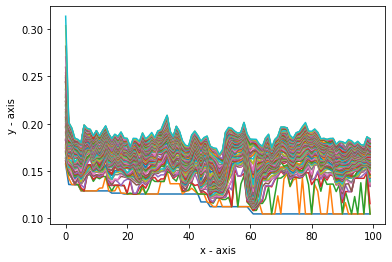

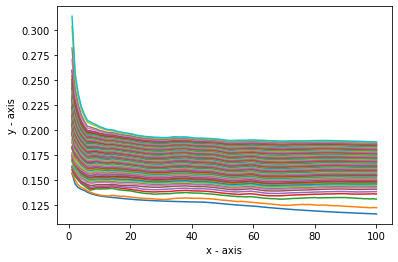

model_id: 60_38
binary_features: [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
error: 0.10449481367652713
metric: 0.8955051863234729
fitness: 295.5
time: 17min 20s


In [20]:
col_names = ["MouseID", "DYRK1A_N", "ITSN1_N", "BDNF_N", "NR1_N", "NR2A_N", "pAKT_N", "pBRAF_N", "pCAMKII_N", "pCREB_N", "pELK_N", "pERK_N", "pJNK_N", "PKCA_N", "pMEK_N", "pNR1_N", "pNR2A_N", "pNR2B_N", "pPKCAB_N", "pRSK_N", "AKT_N", "BRAF_N", "CAMKII_N", "CREB_N", "ELK_N", "ERK_N", "GSK3B_N", "JNK_N", "MEK_N", "TRKA_N", "RSK_N", "APP_N", "Bcatenin_N", "SOD1_N", "MTOR_N", "P38_N", "pMTOR_N", "DSCR1_N", "AMPKA_N", "NR2B_N", "pNUMB_N", "RAPTOR_N", "TIAM1_N", "pP70S6_N", "NUMB_N", "P70S6_N", "pGSK3B_N", "pPKCG_N", "CDK5_N", "S6_N", "ADARB1_N", "AcetylH3K9_N", "RRP1_N", "BAX_N", "ARC_N", "ERBB4_N", "nNOS_N", "Tau_N", "GFAP_N", "GluR3_N", "GluR4_N", "IL1B_N", "P3525_N", "pCASP9_N", "PSD95_N", "SNCA_N", "Ubiquitin_N", "pGSK3B_Tyr216_N", "SHH_N", "BAD_N", "BCL2_N", "pS6_N", "pCFOS_N", "SYP_N", "H3AcK18_N", "EGR1_N", "H3MeK4_N", "CaNA_N", "Genotype", "Treatment", "Behavior", "class", "label"]
dataset = pd.read_csv("Data_Cortex_Nuclear.csv", header=0, names=col_names).fillna(0)


feature_list = ["DYRK1A_N", "ITSN1_N", "BDNF_N", "NR1_N", "NR2A_N", "pAKT_N", "pBRAF_N", "pCAMKII_N", "pCREB_N", "pELK_N", "pERK_N", "pJNK_N", "PKCA_N", "pMEK_N", "pNR1_N", "pNR2A_N", "pNR2B_N", "pPKCAB_N", "pRSK_N", "AKT_N", "BRAF_N", "CAMKII_N", "CREB_N", "ELK_N", "ERK_N", "GSK3B_N", "JNK_N", "MEK_N", "TRKA_N", "RSK_N", "APP_N", "Bcatenin_N", "SOD1_N", "MTOR_N", "P38_N", "pMTOR_N", "DSCR1_N", "AMPKA_N", "NR2B_N", "pNUMB_N", "RAPTOR_N", "TIAM1_N", "pP70S6_N", "NUMB_N", "P70S6_N", "pGSK3B_N", "pPKCG_N", "CDK5_N", "S6_N", "ADARB1_N", "AcetylH3K9_N", "RRP1_N", "BAX_N", "ARC_N", "ERBB4_N", "nNOS_N", "Tau_N", "GFAP_N", "GluR3_N", "GluR4_N", "IL1B_N", "P3525_N", "pCASP9_N", "PSD95_N", "SNCA_N", "Ubiquitin_N", "pGSK3B_Tyr216_N", "SHH_N", "BAD_N", "BCL2_N", "pS6_N", "pCFOS_N", "SYP_N", "H3AcK18_N", "EGR1_N", "H3MeK4_N", "CaNA_N"]
model_errors, model_metrics, best_model_m_more_random = run_feature_selection_more_random(n_models=100,
                                                                              generations=100,
                                                                              feature_list=feature_list,
                                                                              dataset=dataset)

plot_errors(error_list=model_errors)
plot_cum_errors(error_list=model_errors)
for k,v in best_model_m_more_random.__dict__.items():
    print(f"{k}: {v}")

Gen: 0, [0.1497722408210308, 0.15438230613028947, 0.15520553207837118, 0.1567971022446628, 0.16727951265023877, 0.16766368475934368, 0.1681576203281927, 0.17199934141924145, 0.17282256736732338, 0.17556665386092973, 0.17957302014159482, 0.18001207398057184, 0.18028648262993252, 0.18050600954942098, 0.18050600954942098, 0.1816585258767356, 0.18182317106635204, 0.18215246144558483, 0.18368914988200435, 0.18429284891059772, 0.18467702101970251, 0.185774655617145, 0.18621370945612192, 0.18626859118599426, 0.18632347291586637, 0.18659788156522694, 0.18846386038087926, 0.19043960265627569, 0.1915921189835904, 0.19323857087975416, 0.19367762471873118, 0.1937873881784754, 0.19428132374732454, 0.19510454969540636, 0.1963668294824653, 0.19845233521760608, 0.19965973327479292, 0.20196476592942214, 0.20207452938916637, 0.20377586301520223, 0.20602601393995934, 0.20608089566983157, 0.2066297129685527, 0.20684923988804127, 0.2116788321167884, 0.21387410131167328, 0.21530102628834857, 0.2160144887766

Gen: 30, [0.10564733000384174, 0.10575709346358597, 0.10614126557269077, 0.10751330881949395, 0.10811700784808742, 0.1084462982273201, 0.10861094341693645, 0.10932440590527415, 0.10981834147412317, 0.11009275012348396, 0.11014763185335608, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.11042204050271665, 0.1106415674222051, 0.11064156742220521, 0.11069644915207733, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.11075133088194944, 0.1109708578014379, 0.110970857801438, 0.110970857801438, 0.110970857801438, 0.110970857801438, 0.110970857801438, 0.110970857801438, 0.110970857801438, 0.110970857801438, 0.110970857801438, 0.1

C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Gen: 40, [0.09543932824762635, 0.09543932824762635, 0.09587838208660338, 0.09593326381647538, 0.09593326381647549, 0.09593326381647549, 0.09593326381647549, 0.09593326381647549, 0.09593326381647549, 0.09593326381647549, 0.0959881455463476, 0.09598814554634771, 0.09626255419570828, 0.09626255419570828, 0.0963174359255804, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09648208111519674, 0.09659184457494108, 0.09664672630481308, 0.09664672630481308, 0.09664672630481308, 0.09686625322430154, 0.09708578014379021, 0.09719554360353444, 0.09746995225289501, 0.09768947917238346, 0.09768947917238346, 0.09768947917238346, 0.09768947917238346, 0.09768947917238346, 0.09768947917238358, 0.09774436090225558, 0.09774436090225558, 0.09774436090225569, 0.09796388782174414, 0.09801876955161637, 0.098

C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Graeme.crawley\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Gen: 50, [0.08797541298501732, 0.08797541298501732, 0.08803029471488932, 0.08868887547335491, 0.08868887547335491, 0.08896328412271559, 0.0890181658525877, 0.08918281104220394, 0.08918281104220405, 0.08951210142143695, 0.08962186488118107, 0.08962186488118107, 0.08967674661105307, 0.0897316283409254, 0.08995115526041375, 0.08995115526041386, 0.08995115526041386, 0.08995115526041386, 0.0901706821799022, 0.09028044563964654, 0.090445090829263, 0.090445090829263, 0.090499972559135, 0.090499972559135, 0.090499972559135, 0.09049997255913511, 0.09049997255913511, 0.09060973601887934, 0.09060973601887934, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875134, 0.09066461774875

Gen: 80, [0.08276164864716529, 0.08276164864716529, 0.08325558421601453, 0.08331046594588665, 0.08331046594588665, 0.08331046594588665, 0.08331046594588665, 0.0835299928653751, 0.08358487459524722, 0.08358487459524722, 0.08358487459524722, 0.08358487459524722, 0.08391416497448001, 0.08391416497448001, 0.08391416497448001, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08424345535371269, 0.08

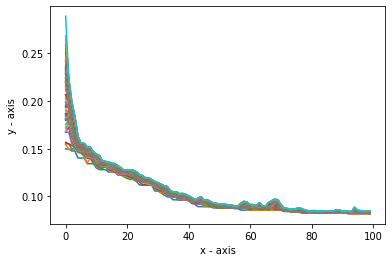

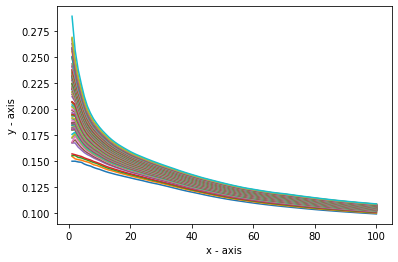

model_id: 91_90
binary_features: [0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]
error: 0.0817188957795949
metric: 0.9182811042204051
fitness: 220.5
time: 11min 52s


In [395]:
col_names = ["MouseID", "DYRK1A_N", "ITSN1_N", "BDNF_N", "NR1_N", "NR2A_N", "pAKT_N", "pBRAF_N", "pCAMKII_N", "pCREB_N", "pELK_N", "pERK_N", "pJNK_N", "PKCA_N", "pMEK_N", "pNR1_N", "pNR2A_N", "pNR2B_N", "pPKCAB_N", "pRSK_N", "AKT_N", "BRAF_N", "CAMKII_N", "CREB_N", "ELK_N", "ERK_N", "GSK3B_N", "JNK_N", "MEK_N", "TRKA_N", "RSK_N", "APP_N", "Bcatenin_N", "SOD1_N", "MTOR_N", "P38_N", "pMTOR_N", "DSCR1_N", "AMPKA_N", "NR2B_N", "pNUMB_N", "RAPTOR_N", "TIAM1_N", "pP70S6_N", "NUMB_N", "P70S6_N", "pGSK3B_N", "pPKCG_N", "CDK5_N", "S6_N", "ADARB1_N", "AcetylH3K9_N", "RRP1_N", "BAX_N", "ARC_N", "ERBB4_N", "nNOS_N", "Tau_N", "GFAP_N", "GluR3_N", "GluR4_N", "IL1B_N", "P3525_N", "pCASP9_N", "PSD95_N", "SNCA_N", "Ubiquitin_N", "pGSK3B_Tyr216_N", "SHH_N", "BAD_N", "BCL2_N", "pS6_N", "pCFOS_N", "SYP_N", "H3AcK18_N", "EGR1_N", "H3MeK4_N", "CaNA_N", "Genotype", "Treatment", "Behavior", "class", "label"]
dataset = pd.read_csv("Data_Cortex_Nuclear.csv", header=0, names=col_names).fillna(0)


feature_list = ["DYRK1A_N", "ITSN1_N", "BDNF_N", "NR1_N", "NR2A_N", "pAKT_N", "pBRAF_N", "pCAMKII_N", "pCREB_N", "pELK_N", "pERK_N", "pJNK_N", "PKCA_N", "pMEK_N", "pNR1_N", "pNR2A_N", "pNR2B_N", "pPKCAB_N", "pRSK_N", "AKT_N", "BRAF_N", "CAMKII_N", "CREB_N", "ELK_N", "ERK_N", "GSK3B_N", "JNK_N", "MEK_N", "TRKA_N", "RSK_N", "APP_N", "Bcatenin_N", "SOD1_N", "MTOR_N", "P38_N", "pMTOR_N", "DSCR1_N", "AMPKA_N", "NR2B_N", "pNUMB_N", "RAPTOR_N", "TIAM1_N", "pP70S6_N", "NUMB_N", "P70S6_N", "pGSK3B_N", "pPKCG_N", "CDK5_N", "S6_N", "ADARB1_N", "AcetylH3K9_N", "RRP1_N", "BAX_N", "ARC_N", "ERBB4_N", "nNOS_N", "Tau_N", "GFAP_N", "GluR3_N", "GluR4_N", "IL1B_N", "P3525_N", "pCASP9_N", "PSD95_N", "SNCA_N", "Ubiquitin_N", "pGSK3B_Tyr216_N", "SHH_N", "BAD_N", "BCL2_N", "pS6_N", "pCFOS_N", "SYP_N", "H3AcK18_N", "EGR1_N", "H3MeK4_N", "CaNA_N"]
model_errors, model_metrics, best_model_m_more_random = run_feature_selection_one_family_tree_always_best_parents(n_models=100,
                                                                              generations=100,
                                                                              feature_list=feature_list,
                                                                              dataset=dataset)

plot_errors(error_list=model_errors)
plot_cum_errors(error_list=model_errors)
for k,v in best_model_m_more_random.__dict__.items():
    print(f"{k}: {v}")